## RISEI - Randomized Input Sampling for Explanations with Inpainting

In [1]:
import os
import cv2

import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.transform import resize

from tensorflow.keras import preprocessing

from PIL import Image

In [2]:
class RISEI():
    def __init__(self, input_size, **kwargs):
        self.input_size = input_size
        
        self.s = kwargs.get('s', 8) # size of the "grid" - binary mask
        self.p1 = kwargs.get('p1', 0.5) # probability of cell being white - transparent
        
        self.b1 = kwargs.get('b1', 0.8) # inpaint mask blend
        self.b2 = kwargs.get('b2', 0.5) # black mask blend
        
        self.debug = kwargs.get('debug', False)
        self.cache = None
        
        self.inpaint_radius = kwargs.get('inpaint_radius', 20) # inpainting radius
        self.inpaint_algorithm = kwargs.get('inpaint_algorithm', cv2.INPAINT_TELEA) # cv2.INPAINT_TELEA, cv2.INPAINT_NS
        
        self.__get_grid_size()
    
    def generate_masks(self, N, image):
        self.__initialize_cache(N, image)
        
        image_data = np.array(image).astype(np.uint8)
        
        grids = self.__get_empty_grids(N)
        images_data = self.__get_empty_images_data(N)
    
        for i in tqdm(range(N), desc='Generating masks'):
            shift_x, shift_y = self.__get_random_shift()
            
            mask = self.__get_mask(grids[i], shift_x, shift_y)
            binary_mask = self.__get_binary_mask(grids[i], shift_x, shift_y)
            inpaint_mask = self.__get_inpaint_mask(image_data, binary_mask)
            
            images_data[i, :, :, :] = self.__merge(image, mask, inpaint_mask)
            
            if self.debug:
                self.__save_to_cache(i, images_data[i], grids[i], mask, binary_mask, inpaint_mask)
            
        return images_data
    
    def show_from_last_run(self, i, figsize=(12, 8), ncols=3, nrows=2):
        original_image = self.show_image_from_last_run(i)
        mask = self.show_mask_from_last_run(i)
        binary_mask = self.show_binary_mask_from_last_run(i)
        inpaint = self.show_inpaint_from_last_run(i)
        result = self.show_result_from_last_run(i)

        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        ax = axes.ravel()

        ax[0].set_title('Original')
        ax[0].imshow(original_image)

        ax[1].set_title('Binary mask')
        ax[1].imshow(binary_mask)

        ax[2].set_title('Mask')
        ax[2].imshow(mask)

        ax[3].set_title('Inpaint')
        ax[3].imshow(inpaint)

        ax[4].set_title('Result')
        ax[4].imshow(result)

        for a in ax:
            a.axis('off')

        fig.tight_layout()
        plt.show()
    
    def show_mask_from_last_run(self, i):
        mask = self.__get_from_cache('masks', i)
        w, h = self.input_size
        
        image = 255 * np.ones((h, w, 3), dtype=np.uint8)
        new_image = image * mask.reshape((*self.input_size, 1))
        
        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_binary_mask_from_last_run(self, i):
        binary_mask = self.__get_from_cache('binary_masks', i)
        w, h = self.input_size
        
        image = 255 * np.ones((h, w, 3), dtype=np.uint8)
        new_image = image * binary_mask.reshape((*self.input_size, 1))
        
        return Image.fromarray(new_image.astype(np.uint8), 'RGB')
        
    def show_image_from_last_run(self, i):
        return image    

    def show_inpaint_from_last_run(self, i):
        inpaint_mask = self.__get_from_cache('inpaint_masks', i)
        return Image.fromarray(inpaint_mask.astype(np.uint8), 'RGB')
    
    def show_result_from_last_run(self, i):
        image_data = self.__get_from_cache('images_data', i)
        return Image.fromarray(image_data.astype(np.uint8), 'RGB')    
    
    def __get_from_cache(self, key, i):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')
        if len(self.cache[key]) <= i:
            raise Exception(f'Index {i} does not exist!')
        return self.cache[key][i]
    
    def __save_to_cache(self, i, image_data, grid, mask, binary_mask, inpaint_mask):
        self.cache['images_data'][i, :, :, :] = image_data
        self.cache['grids'][i, :, :] = grid
        self.cache['masks'][i, :, :] = mask
        self.cache['binary_masks'][i, :, :] = binary_mask
        self.cache['inpaint_masks'][i, :, :, :] = inpaint_mask        
    
    def __initialize_cache(self, N, image):
        if self.debug:
            self.cache = {
                'image': image,
                'images_data': np.empty((N, *self.input_size, 3)),                
                'grids': np.empty((N, self.s, self.s)),
                'masks': np.empty((N, *self.input_size)),
                'binary_masks': np.empty((N, *self.input_size)),
                'inpaint_masks': np.empty((N, *self.input_size, 3)),
            }
        else:
            self.cache = None
            
    def __merge(self, original_image, mask, inpaint_mask):
        # convert inpaint mask from array to image so we can blend it
        inpaint_image = Image.fromarray(inpaint_mask.astype(np.uint8), 'RGB')

        # blend original image with inpaint mask and convert it to array
        new_image = np.array(Image.blend(original_image, inpaint_image, alpha=self.b1))

        # blend original image with inpaint mask with mask
        new_image = new_image * (1 - ((1 - mask.reshape((*self.input_size, 1))) * self.b2))
        
        return new_image
            
    def __get_inpaint_mask(self, image_data, binary_mask):
        # we need to invert our binary mask, since ones stands for
        # locations to be inpainted in cv2.inpaint algorithm
        return cv2.inpaint(
            image_data,
            1 - binary_mask.astype(np.uint8),
            self.inpaint_radius,
            self.inpaint_algorithm
        )
            
    def __get_empty_grids(self, N):
        grids = np.random.rand(N, self.s, self.s) < self.p1
        return grids.astype('float32')
    
    def __get_empty_images_data(self, N):
        return np.empty((N, *self.input_size, 3))
    
    def __get_random_shift(self):
        shift_x = np.random.randint(0, self.over_image_size[0])
        shift_y = np.random.randint(0, self.over_image_size[1])        
        
        return shift_x, shift_y 
    
    def __get_mask(self, grid, shift_x, shift_y):
        return resize(grid,
               self.mask_size,
               order=1,
               mode='reflect',
               anti_aliasing=False)[shift_y:shift_y + self.input_size[0], shift_x:shift_x + self.input_size[1]]
    
    def __get_binary_mask(self, grid, shift_x, shift_y):
        new_grid = np.zeros(self.mask_size)

        for y in range(0, new_grid.shape[0]):
            for x in range(0, new_grid.shape[1]):
                grid_y = int(y // self.cell_size[0])
                grid_x = int(x // self.cell_size[1])

                new_grid[y][x] = grid[grid_y][grid_x]

        return new_grid[shift_y:input_size[0] + shift_y, shift_x:input_size[1] + shift_x]
            
    def __get_grid_size(self):
        # the size of one pixel (rectangle)
        cell_size = np.ceil(np.array(input_size) / self.s)

        # the additional size for each rectangle
        # since we do a crop from the mask, we
        # need to make a "bigger" mask
        # we calculate how much we need to increase the cell
        # to increase the current size by one additional cell
        over_cell_size = np.ceil((((self.s + 1) * cell_size) - (self.s * cell_size)) / self.s)

        # new cell size
        new_cell_size = cell_size + over_cell_size

        # mask size (mask is larger than the image)
        mask_size = (self.s * new_cell_size).astype(np.uint32)

        # difference in size between original image and mask
        over_image_size = mask_size - input_size

        self.mask_size = mask_size
        self.cell_size = new_cell_size
        self.over_image_size = over_image_size

In [3]:
def load_image(path, input_size):
    img = preprocessing.image.load_img(path, target_size=input_size)
    return img

Generating masks: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


(10, 300, 300, 3)


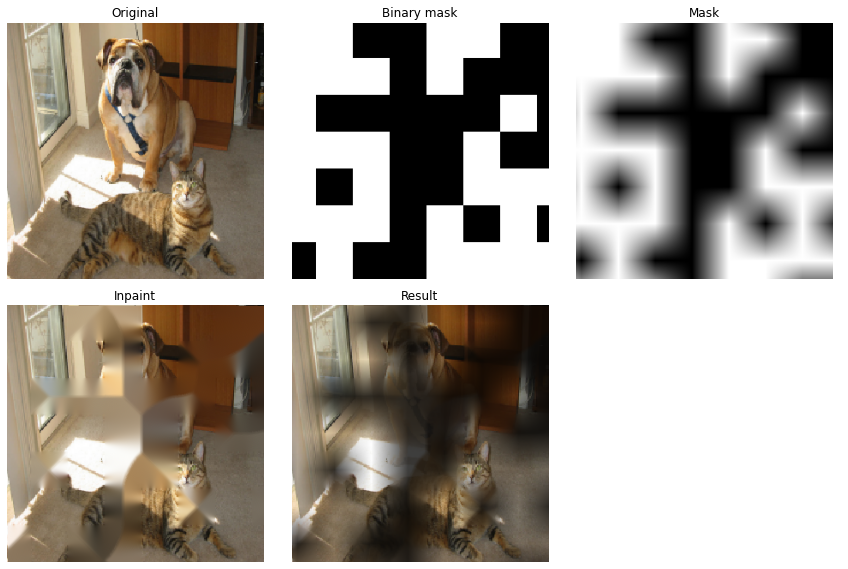

CPU times: user 5.27 s, sys: 162 ms, total: 5.43 s
Wall time: 4.61 s


In [4]:
%%time

input_size = [300, 300]
image = load_image('../data/catdog.png', input_size)

risei = RISEI(input_size, s=8, p1=0.5, b1=0.75, b2=0.75, inpaint_radius=5, debug=True)

masks = risei.generate_masks(10, image)

print(masks.shape)

risei.show_from_last_run(0)

Generating masks: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


(1, 630, 630, 3)


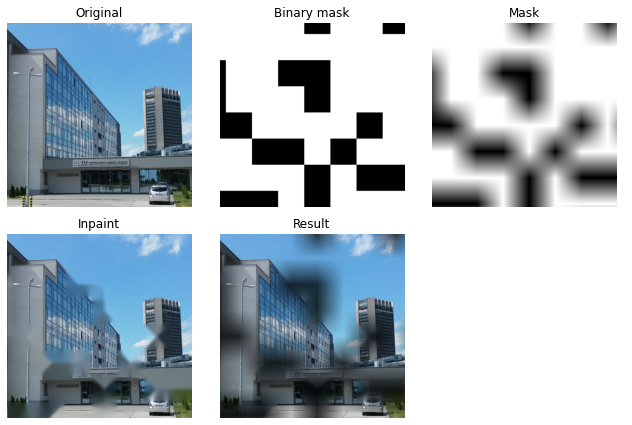

CPU times: user 5.01 s, sys: 90 ms, total: 5.1 s
Wall time: 5.08 s


In [5]:
%%time

input_size = [630, 630]
image = load_image('../data/fiit.jpg', input_size)

risei = RISEI(input_size, s=8, p1=0.75, b1=0.75, b2=0.75, inpaint_radius=15, debug=True)

masks = risei.generate_masks(1, image)

print(masks.shape)

risei.show_from_last_run(0, figsize=(9, 6))